In [8]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# here I have a dataset with about 3000 rows, where force = sin(velocity)*cos(velocity)+random_number_betw_0_1
my_dataframe = pd.read_csv("esempio.csv", sep=",")

my_dataframe = my_dataframe.reindex(
    np.random.permutation(my_dataframe.index))

In [9]:
def preprocess_features(my_dataframe):
  """Prepares input features from input data set.

  Args:
    my_dataframe: A Pandas DataFrame expected to contain data
      for velocity and force.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features if needed.
  """
  selected_features = my_dataframe[
    ["velocity"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature if necessary.
  #processed_features["new_feature"] = (
    #my_dataframe["velocity"] ... 
  return processed_features

def preprocess_targets(my_dataframe):
  """Prepares target features (i.e., labels) from input data set.

  Args:
    my_dataframe: A Pandas DataFrame expected to contain data
      for velocity and force.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target if necessary
  output_targets["force"] = (
    my_dataframe["force"])  # / 1000.0)
  return output_targets

In [10]:
# Choose the first 2000 (out of 3000) examples for training.
training_examples = preprocess_features(my_dataframe.head(20000))
training_targets = preprocess_targets(my_dataframe.head(20000))

# Choose the last 1000 (out of 3000) examples for validation.
validation_examples = preprocess_features(my_dataframe.tail(10000))
validation_targets = preprocess_targets(my_dataframe.tail(10000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
display.display(training_examples)
print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())



Training examples summary:


,velocity
count,20000.0
mean,0.0
std,0.0
min,-0.2
25%,-0.0
50%,0.0
75%,0.0
max,0.2


Validation examples summary:


,velocity
count,10000.0
mean,-0.0
std,0.0
min,-0.2
25%,-0.0
50%,0.0
75%,0.0
max,0.1


,velocity
37727,0.0
62002,0.0
38770,0.0
24,0.0
19680,0.1
...,...
42709,-0.0
27605,-0.0
47632,-0.0
61796,0.0


Training targets summary:


,force
count,20000.0
mean,-0.0
std,3.7
min,-14.4
25%,-0.1
50%,-0.0
75%,0.0
max,14.7


Validation targets summary:


,force
count,10000.0
mean,0.0
std,3.6
min,-14.1
25%,-0.1
50%,-0.0
75%,0.1
max,14.7


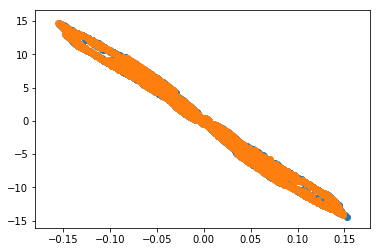

In [11]:
plt.scatter(training_examples.values, training_targets.values)
plt.scatter(validation_examples.values, validation_targets.values)

In [12]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [13]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [14]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    activation_fn,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `my_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `my_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `my_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `my_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units, activation_fn=activation_fn,
      optimizer=my_optimizer,
  )
  # this model does not accept a specialized activation function for each level: all levels use the same a.f.
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["force"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["force"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["force"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 3.64
  period 01 : 3.58
  period 02 : 3.45
  period 03 : 3.24
  period 04 : 2.96
  period 05 : 2.74
  period 06 : 2.15
  period 07 : 1.64
  period 08 : 1.61
  period 09 : 1.47
Model training finished.
Final RMSE (on training data):   1.47
Final RMSE (on validation data): 1.47


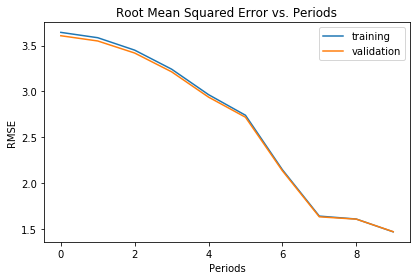

In [15]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=8,
    hidden_units=[18, 18,18,18,18],
    activation_fn="relu",
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [16]:
my_test_data = pd.read_csv("esempio_test.csv", sep=",")
test_examples = preprocess_features(my_test_data)
test_targets = preprocess_targets(my_test_data)
test_input_fn = lambda: my_input_fn(test_examples, 
                                    test_targets["force"], 
                                    num_epochs=1, 
                                    shuffle=False)
test_predictions = dnn_regressor.predict(input_fn=test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 1.54


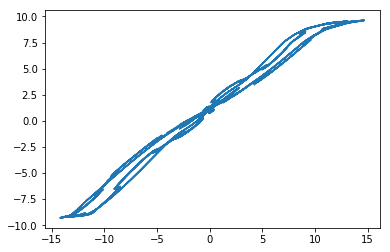

In [17]:
plt.plot(test_targets,test_predictions)